# Goal:
First, I create models with bag of words and then move on to modeling with word2vec.  
On this notebook, I will:
- Create bag of words for reviews
- Create models with it 
- Test the performance

source: [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

In [27]:
reset -sf

In [2]:
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

## Read the data and preprocess

In [3]:
df = pd.read_csv('../../projects/alchemyapi/alchemyapi_python/data/df_clearn_en_alchemy_sentiment.csv').drop('Unnamed: 0', 1)
df.head()

,review_id,review_scores_rating,comments,Sentiment,alchemy_sentiment,alchemy_sentiment_score
0,10612780,92,Great host. Provided special gift basket upon ...,1,positive,0.692647
1,49925683,92,Great host. Met me at apartment. Place was cle...,1,positive,0.646267
2,50537634,92,Syeda hosted my parents for four days during t...,No_label,positive,0.656386
3,51077613,92,I had a great experience at Syeda's Airbnb! It...,1,positive,0.817832
4,52109034,92,"Great location! Warm, welcoming host. This w...",No_label,positive,0.845319


In [4]:
# make score string int float 
def to_float(x): 
    try:
        return float(x)
    except:
        return 'no_data'

df.alchemy_sentiment_score = df['alchemy_sentiment_score'].apply(to_float)
# change_val(df.alchemy_sentiment_score[132331])

In [5]:
type(df.alchemy_sentiment_score[10])

float

In [6]:
# make float into 1 for positive sentiment or -1 for negative sentiment
def give_sentiment(x):
    try:
        if x == 'no_data':
            return 'no_data'
        elif x > 0.:
            return 1
        elif x < 0.:
            return -1
    except:
        return 'no_data'

df.alchemy_sentiment = df['alchemy_sentiment_score'].apply(give_sentiment)
# give_sentiment(df.alchemy_sentiment_score[132331])

In [7]:
Counter(df.alchemy_sentiment)

Counter({-1: 285, 1: 4263, 'no_data': 127784})

## Create words list for each reveiw
- Making sure if string is utf8
- Delete punctuation and number
- Take out stop words and lemmatize

In [8]:
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

# Use regular expressions to find and replace
def review_to_wordlist(x, remove_stopwords=True): #stop word as optional
    x = str(x)
    x = x.decode("utf8")
    
    wordnet_lemmatizer = WordNetLemmatizer()
    x = re.sub("[^a-zA-Z]", " ", x)    
    x = x.lower().split()

    if remove_stopwords:
        stops = set(stopwords.words("english")) # set is faster than list
        x = [wordnet_lemmatizer.lemmatize(word) for word in x if word not in stops]
    return " ".join(x)

df.comments = df['comments'].apply(review_to_wordlist)

### Make positive/negative/non-labeled dataframes

In [14]:
pos_df = df[df['alchemy_sentiment'] == 1]
neg_df = df[df['alchemy_sentiment'] == -1]
no_label_df = df[df['alchemy_sentiment'] == 'no_data']
print len(pos_df),len(neg_df),len(no_label_df)

4263 285 127784


### Make positive/negative/non-labeled lists and label (y) list

In [15]:
pos_list = list(pos_df.comments)
neg_list = list(neg_df.comments)
no_label_list = list(no_label_df.comments)
y = np.concatenate((np.ones(len(pos_list)), -1*np.ones(len(neg_list))))

### Create test/train sets

In [16]:
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_list, neg_list)), y, test_size=0.2)

In [17]:
len(x_train), len(x_test), len(y_train), len(y_test) 

(3638, 910, 3638, 910)

### Create bag of words

In [18]:
print "Creating the bag of words...\n"
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object 
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit & transform features
train_data_features = vectorizer.fit_transform(x_train)
test_data_features =  vectorizer.transform(x_test)

# convert into Numpy arrays for ease
train_data_features = train_data_features.toarray()
test_data_features = test_data_features.toarray()

Creating the bag of words...



In [19]:
print train_data_features.shape
print test_data_features.shape

(3638, 5000)
(910, 5000)


In [20]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print vocab[:10]

[u'aaron', u'ab', u'abandoned', u'abe', u'ability', u'abit', u'able', u'abosultely', u'abound', u'abroad']


## Let's model

### Random forest

In [21]:
print "Training..."
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as features and the sentiment labels as the response variable
forest = forest.fit( train_data_features,y_train )

Training...


### Performance check

Test Accuracy:  0.956043956044
Confution matrix 
[[ 13  38]
 [  2 857]]
             precision    recall  f1-score   support

   negative       0.87      0.25      0.39        51
   positive       0.96      1.00      0.98       859

avg / total       0.95      0.96      0.94       910



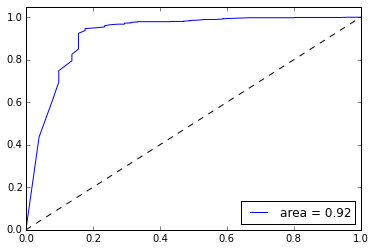

In [22]:
from performance import run_performance #custom test python file
run_performance(forest, test_data_features, y_test)

- It cannot capture negative sentiment well

### Since class is imbalanced, let's set class weight param as 'balanced'
- The “balanced” class weight param uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)) 
- reference: [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [23]:
# balanced RF
print "Training..."
forest_balanced = RandomForestClassifier(n_estimators = 100, class_weight='balanced') 

forest_balanced = forest_balanced.fit( train_data_features,y_train )

Training...


Test Accuracy:  0.952747252747
Confution matrix 
[[  9  42]
 [  1 858]]
             precision    recall  f1-score   support

   negative       0.90      0.18      0.30        51
   positive       0.95      1.00      0.98       859

avg / total       0.95      0.95      0.94       910



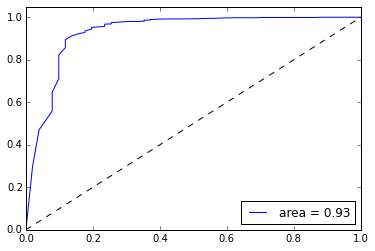

In [24]:
run_performance(forest_balanced, test_data_features, y_test)

- Balancing the class labels didn't fix the problem with random forest classifier. 

### SVM
- Now, let's use SVM since it's conceptually good at handling imbalanced data

In [25]:
print "Training ..."
from sklearn.svm import SVC

# Initialize a SVC classifier
svc = SVC(probability=True) 

svc = svc.fit( train_data_features,y_train )

Training ...


Test Accuracy:  0.943956043956
Confution matrix 
[[  0  51]
 [  0 859]]
             precision    recall  f1-score   support

   negative       0.00      0.00      0.00        51
   positive       0.94      1.00      0.97       859

avg / total       0.89      0.94      0.92       910



/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


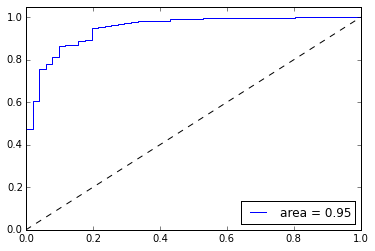

In [26]:
run_performance(svc, test_data_features, y_test)

- Not working.. 

### Let's enable class weight here as well.

In [27]:
# balanced
print "Training ..."
from sklearn.svm import SVC

# Initialize SVC classifier with class_weight='balanced'
svc_balanced = SVC(probability=True, class_weight='balanced') 

svc_balanced = svc_balanced.fit( train_data_features,y_train )

Training ...


Test Accuracy:  0.952747252747
Confution matrix 
[[ 33  18]
 [ 25 834]]
             precision    recall  f1-score   support

   negative       0.57      0.65      0.61        51
   positive       0.98      0.97      0.97       859

avg / total       0.96      0.95      0.95       910



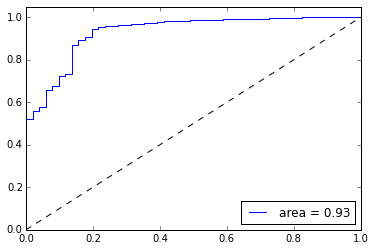

In [28]:
run_performance(svc_balanced, test_data_features, y_test)

- SVM with balanced class weight is better at identifying negative sentiment but it's not good enough. Move on to the second part.